# Inverting the Lens Equation

The lens equation $\vec{\beta} = \vec{\theta} - \vec{\alpha}(\vec{\theta})$ allows us to find a point in the source plane given a point in the image plane. However, sometimes we know a point in the source plane and would like to see where it ends up in the image plane. This is not easy to do since a point in the source plane may map to multiple locations in the image plane. There is no closed form function to invert the lens equation, in large part because the deflection angle $\vec{\alpha}$ depends on the position in the image plane $\vec{\theta}$. To invert the lens equation, we will need to rely on optimization and a little luck to find all the images for a given source plane point. Below we will demonstrate how this is done in caustic!

In [1]:
%load_ext autoreload
%autoreload 2

from functools import partial

import torch
from torch.nn.functional import avg_pool2d
import matplotlib.pyplot as plt
from ipywidgets import interact
from astropy.io import fits
import numpy as np
from time import process_time as time

import caustics

In [2]:
# initialization stuff for an SIE lens

cosmology = caustics.cosmology.FlatLambdaCDM(name="cosmo")
cosmology.to(dtype=torch.float32)
n_pix = 100
res = 0.05
upsample_factor = 1
fov = res * n_pix
thx, thy = caustics.utils.get_meshgrid(
    res / upsample_factor,
    upsample_factor * n_pix,
    upsample_factor * n_pix,
    dtype=torch.float32,
)
z_l = torch.tensor(0.5, dtype=torch.float32)
z_s = torch.tensor(1.5, dtype=torch.float32)
lens = caustics.lenses.SIE(
    cosmology=cosmology,
    name="sie",
    z_l=z_l,
    x0=torch.tensor(0.0),
    y0=torch.tensor(0.0),
    q=torch.tensor(0.4),
    phi=torch.tensor(np.pi / 5),
    b=torch.tensor(1.0),
    s = 1e-3,
)

In [3]:
# Point in the source plane
sp_x = torch.tensor(0.2)
sp_y = torch.tensor(0.2)

# Points in image plane
x, y = lens.forward_raytrace(sp_x, sp_y, z_s)

# Raytrace to check
bx, by = lens.raytrace(x, y, z_s)

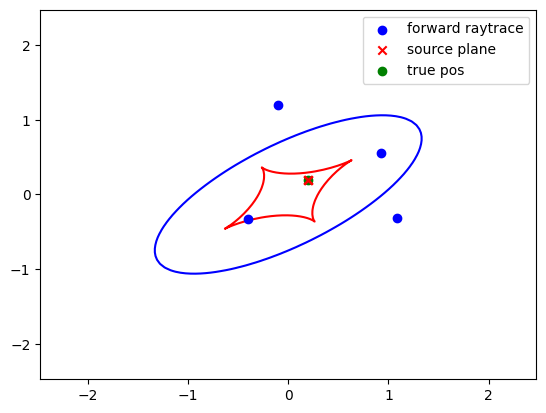

In [4]:
fig, ax = plt.subplots()

A = lens.jacobian_lens_equation(thx, thy, z_s)
detA = torch.linalg.det(A)

CS = ax.contour(thx, thy, detA, levels=[0.0], colors="b", zorder=1)
# Get the path from the matplotlib contour plot of the critical line
paths = CS.allsegs[0]
caustic_paths = []
for path in paths:
    # Collect the path into a discrete set of points
    x1 = torch.tensor(list(float(vs[0]) for vs in path))
    x2 = torch.tensor(list(float(vs[1]) for vs in path))
    # raytrace the points to the source plane
    y1, y2 = lens.raytrace(x1, x2, z_s)

    # Plot the caustic
    ax.plot(y1, y2, color="r", zorder=1)
ax.scatter(x, y, color="b", label="forward raytrace", zorder=10)
ax.scatter(bx, by, color="r", marker="x", label="source plane", zorder=9)
ax.scatter([sp_x.item()], [sp_y.item()], color="g", label="true pos", zorder=8)
plt.legend()
plt.show()

tensor(0.)


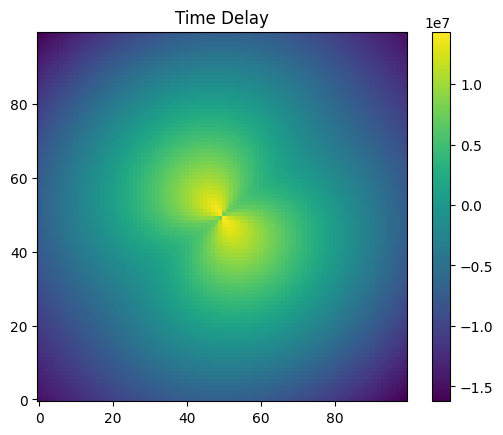

In [5]:
TD = lens.time_delay(thx, thy, z_s)

plt.imshow(TD.detach().cpu().numpy(), origin="lower")
plt.colorbar()
plt.title("Time Delay")
plt.show()